<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Kernel-PCA-Example" data-toc-modified-id="Kernel-PCA-Example-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Kernel PCA Example</a></span></li><li><span><a href="#Isomap-Example" data-toc-modified-id="Isomap-Example-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Isomap Example</a></span></li><li><span><a href="#LLE-Example" data-toc-modified-id="LLE-Example-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>LLE Example</a></span></li><li><span><a href="#UMAP-Example" data-toc-modified-id="UMAP-Example-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>UMAP Example</a></span></li></ul></div>

In [2]:
import numpy as np
import scipy
import sklearn.decomposition
import sklearn.manifold
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_array, check_is_fitted, check_X_y
from sklearn.covariance import EmpiricalCovariance, MinCovDet
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class EllipticManifold(ClassifierMixin, BaseEstimator):
    """
    Perform a dimensionality reduction with decision boundary determined by an ellipse.
    
    This process can be summarized as follows:
    
    Step 1: Perform a dimensionality reduction step using some model to obtain
    a projection ("scores").  
    
    Step 2: Following [1], treat each class separately and assume 
    that they form the normally distributed subsets with the known means in the
    score space.  The covariance matrix is used to compute the 
    [Mahalanobis distance](https://en.wikipedia.org/wiki/Mahalanobis_distance) to
    its class center.
    
    Step 3: Assuming that these distances follow the chi‐squared distribution, a 
    soft discrimination rule can be constructed: sample i belongs to class k if the 
    Mahalanobis distance is less than a threshold:
    
    c_{crit} = \Chi^{-2}(1 - \alpha; d)
    
    where d is the dimensionality of the score space.
    
    This is similar to using scikit-learn's EllipticEnvelope (EE) after some dimensionality
    reduction step; EE essentially learns an ellipse around a known class, with 
    some predefined amount of the observations set to be "included."  The basic 
    difference is that a statistical confidence limit (alpha) can be directly 
    specified here. EE's "contamination" is approximately alpha (Type I error 
    rate); however, this seems to lack some rigor. Here the Chi Squared 
    distribution has some degrees of freedom associated with based on the 
    dimensionality of the space, whereas EE just takes the fraction as a hyperparameter 
    with no context. As a result, many of the class members and functions follow a 
    similar API.
    
    However, Mahalanobis distances are known to suffer from "masking" (multiple
    outliers skew the training so no individual seems "too bad"). EE uses the
    robust algorithm from [2,3] which aims to prevent this.
    
    scikit-learn has an excellent demonstration of this here:
    https://scikit-learn.org/stable/auto_examples/covariance/plot_mahalanobis_\
    distances.html?highlight=outlier%20detection
    
    As a result, you can select either the conventional empirical method or the
    robust method to compute the Mahalanobis distances.
    
    [1] "Multiclass partial least squares discriminant analysis: Taking the
    right way - A critical tutorial," Pomerantsev and Rodionova, Journal of
    Chemometrics (2018). https://doi.org/10.1002/cem.3030.
    [2] "A fast algorithm for the minimum covariance determinant estimator," 
    Rousseeuw, Peter J., and Katrien Van Driessen, Technometrics 41 (1999) 
    212-223. https://www.tandfonline.com/doi/abs/10.1080/00401706.1999.10485670
    [3] "Least median of squares regression," P. J. Rousseeuw., J. Am Stat Ass., 
    79 (1984).
    """
    def __init__(self, alpha, model, kwargs, ndims="n_components", robust=True):
        """
        Instantiate the class.
        
        Parameters
        ----------
        alpha : float
            Type I error rate (signficance level).
        model : object
            Dimensionality reduction model, such as PCA; must support fit() and transform().
        kwargs : dict
            Keyword arguments for model; EllipticManifold.model = model(**kwargs). Must
            contain the `ndims` keyword.
        ndims : str
            Keyword in kwargs that corresponds to the dimensionality of the final space.
        robust : bool
            Whether or not use a robust estimate of the covariance matrix [2,3] to compute the
            Mahalanobis distances.
        """
        self.set_params(
            **{
                "alpha": alpha,
                "model": model,
                "kwargs": kwargs,
                "ndims": ndims,
                "robust": robust
            }
        )
        self.is_fitted_ = False
        
    def set_params(self, **parameters):
        """Set parameters; for consistency with sklearn's estimator API."""
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def get_params(self, deep=True):
        """Get parameters; for consistency with sklearn's estimator API."""
        return {
            "alpha": self.alpha,
            "model": self.model,
            "kwargs": self.kwargs,
            "ndims": self.ndims,
            "robust": self.robust
        }
    
    def column_y_(self, y):
        """Convert y to column format."""
        y = np.array(y)
        if y.ndim != 2:
            y = y[:, np.newaxis]

        return y
    
    def sanity_(self, X, y, init=False):
        """Check data format and sanity."""
        if y is None:
            X = check_array(X, accept_sparse=False, copy=True)
        else:
            X, y = check_X_y(X, y, accept_sparse=False, copy=True)
            y = self.column_y_(y)
            
        if init:
            self.n_features_in_ = X.shape[1]
        else:
            assert(X.shape[1] == self.n_features_in_), "Incorrect X matrix shape"
            
        return X, y
    
    def fit(self, X, y=None):
        """
        Fit the dimensionality reduction model.
        
        Parameters
        ----------
        X : matrix-like
            Columns of features; observations are rows - will be converted to
            numpy array automatically.
        y : array-like
            Response. Ignored if it is not used (unsupervised methods).
            
        Returns
        -------
        self
        """
        # Sanity checks
        X, y = self.sanity_(X, y, init=True)
        
        # Fit the model
        self.model = model(**self.kwargs)
        self.model.fit(X, y)
        self.is_fitted_ = True
        
        # Compute Mahalanobis critical distance
        if not (self.ndims in self.kwargs):
            raise ValueError("Cannot determined score space dimensionality, {} not in kwargs.".format(self.ndims))
        self.__d_crit_ = scipy.stats.chi2.ppf(
            1.0 - self.alpha, self.kwargs[self.ndims]
        )
        
        # Compute scatter matrix
        self.__class_center_ = self.transform(
            X = np.mean(X, axis=0).reshape(1, -1),
            y = (None if y is None else np.mean(y, axis=0).reshape(1, -1))
        )[0]
        t_train = self.transform(X, y)
        t = (t_train - self.__class_center_)
        
        # See https://scikit-learn.org/stable/auto_examples/\
        # covariance/plot_mahalanobis_distances.html?highlight=outlier%20detection
        if self.robust:
            cov = EmpiricalCovariance().fit(t)
        else:
            cov = MinCovDet().fit(t)
        self.__S_ = cov.covariance_
        
        return self
    
    def transform(self, X, y=None):
        """
        Perform dimensionality reduction on X into the score space.
        
        Parameters
        ----------
        X : matrix-like
            Columns of features; observations are rows - will be converted to
            numpy array automatically.
        y : array-like
            Response. Ignored if it is not used (unsupervised methods).
            
        Returns
        -------
        x_scores : ndarray
            Coordinates of X in lower dimensional space.
        """
        check_is_fitted(self, "is_fitted_")
        X, y = self.sanity_(X, y)
        return self.model.transform(X)
    
    def fit_transform(self, X, y=None):
        """
        Fit the dimensionality reduction model and reduce X into the score space.
        
        Parameters
        ----------
        X : matrix-like
            Columns of features; observations are rows - will be converted to
            numpy array automatically.
        y : array-like
            Response. Ignored if it is not used (unsupervised methods).
            
        Returns
        -------
        x_scores : ndarray
            Coordinates of X in lower dimensional space.
        """
        _ = self.fit(X, y)
        return self.transform(X, y)
    
    def mahalanobis(self, X, y=None):
        """
        Compute the Mahalanobis distance for each sample.
        
        Parameters
        ----------
        X : matrix-like
            Columns of features; observations are rows - will be converted to
            numpy array automatically.
        y : array-like
            Response. Ignored if it is not used (unsupervised methods).

        Returns
        -------
        distances : ndarray
            Mahalanobis distance for each sample.
        """
        check_is_fitted(self, "is_fitted_")
        t_test = self.transform(X, y)
        S_inv = np.linalg.inv(self.__S_)
        
        # Compute distances
        distances = np.diag(
            np.matmul(
                np.matmul(
                    (t_test - self.__class_center_),
                    S_inv,
                ),
                (t_test - self.__class_center_).T,
            )
        )
        assert np.all(distances >= 0), "All distances must be >= 0"
        
        return distances
    
    def predict(self, X, y=None):
        """
        Predict if points are inliers (+1) or outliers (-1).
        
        Parameters
        ----------
        X : matrix-like
            Columns of features; observations are rows - will be converted to
            numpy array automatically.
        y : array-like
            Response. Ignored if it is not used (unsupervised methods).
            
        Returns
        -------
        results : ndarray
            Array of +1 or -1 for inliers and outliers, respectively.
        """
        d = self.mahalanobis(X, y)
        mask = d > self.__d_crit_
        
        # +1/-1 follows sklearn's EllipticEnvelope API
        results = np.ones(len(X)) # Inliers
        results[mask] = -1 # Outliers
        
        return results
    
    def fit_predict(self, X, y=None):
        """
        Fit the dimensionality reduction model and then predict outliers.
        
        Parameters
        ----------
        X : matrix-like
            Columns of features; observations are rows - will be converted to
            numpy array automatically.
        y : array-like
            Response. Ignored if it is not used (unsupervised methods).
            
        Returns
        -------
        results : ndarray
            Array of +1 or -1 for inliers and outliers, respectively.
        """
        _ = self.fit(X, y)
        return self.predict(X, y)
    
    def score_samples(self, X, y=None):
        """
        Score some observations.
        
        Following sklearn's EllipticEnvelope, this returns the negative Mahalanobis
        distance.

        Parameters
        ----------
        X : matrix-like
            Columns of features; observations are rows - will be converted to
            numpy array automatically.
        y : array-like
            Response. Ignored if it is not used (unsupervised methods).
            
        Returns
        -------
        scores : ndarray
            Negative Mahalanobis distance for each sample.
        """
        return -self.mahalanobis(X, y)
    
    def decision_function(self, X, y=None):
        """
        Compute the decision function for each sample.
        
        Following sklearn's EllipticEnvelope, this returns the negative Mahalanobis
        distance shifted by the cutoff distance, so score < 0 implies an outlier
        while score > 0 implies an inlier.
        
        Parameters
        ----------
        X : matrix-like
            Columns of features; observations are rows - will be converted to
            numpy array automatically.
        y : array-like
            Response. Ignored if it is not used (unsupervised methods).
            
        Returns
        -------
        decision_function : ndarray
            Shifted, negative Mahalanobis distance for each sample.
        """
        return self.score_samples(X, y) - (-self.__d_crit_)
        
    def score(self, X, y):
        """
        Parameters
        ----------
        X : matrix-like
            Columns of features; observations are rows - will be converted to
            numpy array automatically.
        y : array-like
            True labels; +1 for inlier, -1 for outlier.
        """
        y = np.array(y)
        assert(len(X) == len(y))
        assert(np.all([a in [-1,1] for a in y])), "y should contain only +/- 1"
        return np.sum(self.predict(X) == y)/len(y)
        
    def visualize(self, X_mats, labels, axes=None):
        check_is_fitted(self, "is_fitted_")
        n = self.kwargs[self.ndims]
        if n == 1:
            return self.visualize_1d(X_mats, labels, axes)
        elif n == 2:
            return self.visualize_2d(X_mats, labels, axes)
        else:
            raise Exception("Cannot visualize {} dimensions".format(n))
            
    def visualize_2d(self, X_mats, labels, axes=None):
        """
        Plot 2D results.

        Parameters
        ----------
        X_mats : list(matrix-like)
            List of different sets of X to plot.
        labels : list
            Labels for each X.
        axes : matplotlib.pyplot.Axes
            Axes to plot results on.  If None, a new figure is created.

        Returns
        -------
        matplotlib.pyplot.Axes
            Figure axes being plotted on.
        """
        check_is_fitted(self, "is_fitted_")
        if self.kwargs[self.ndims] != 2:
            raise Exception(
                "Cannot perform 2D visualization for a {} dimensional score space.".format(self.kwargs[self.ndims])
            )
        if (len(labels) != len(X_mats)):
            raise ValueError("Must provide a label for each set of X")

        def soft_boundary_2d(rmax=10.0, rbins=1000, tbins=180):
            """
            Compute the bounding ellipse.

            Parameters
            ----------
            rmax : float
                Radius to g from class center to look for boundary.
            rbins : int
                Number of points to search from class center (r=0 to r=rmax) for
                boundary.
            tbins : int
                Number of bins to split [0, 2*pi) into around the class center.

            Returns
            -------
            ndarray
                Cutoff boundary.
            """

            def estimate_boundary(rmax, rbins, tbins):
                cutoff = []
                c = self.__class_center_
                for theta in np.linspace(0, 2 * np.pi, tbins):
                    # Walk "outward" until you meet the threshold
                    for r in np.linspace(0, rmax, rbins):
                        sPC = c + r * np.array(
                            [np.cos(theta), np.sin(theta)]
                        )

                        d = np.matmul(
                                np.matmul(
                                    (sPC - c),
                                    np.linalg.inv(self.__S_),
                                ),
                            (sPC - c).reshape(-1, 1),
                        )[0]
                        if d > self.__d_crit_:
                            cutoff.append(sPC)
                            break
                            
                return np.array(cutoff)

            cutoff = estimate_boundary(
                rmax=rmax, 
                rbins=rbins, 
                tbins=tbins
            )

            return cutoff

        if axes is None:
            fig = plt.figure()
            ax = fig.gca()
#             ax.plot(
#                 [self.__class_center_[0]],
#                 [self.__class_center_[1]],
#                 "ks",
#                 alpha=1,
#                 label="Training Class Center",
#             )
        else:
            ax = axes

        cutoff = soft_boundary_2d(
            rmax=np.sqrt(self.__d_crit_/np.max(np.diag(self.__S_))), 
            rbins=1000, 
            tbins=90
        )
        ax.plot(cutoff[:, 0], cutoff[:, 1], color="k")
            
        for i,(X,l) in enumerate(zip(X_mats, labels)):
            T = self.transform(X)
            ax.plot(
                T[:, 0],
                T[:, 1],
                "o",
                alpha=0.5,
                color="C{}".format(i),
                label=l,
            )
            
            ax.axis("equal")
            ax.set_xlabel("PC 1")
            ax.set_ylabel("PC 2")
            ax.legend(loc="best")

        return ax
    
    def visualize_1d(self, X_mats, labels, axes=None):
        """
        Plot 1D results.

        Parameters
        ----------
        axes : matplotlib.pyplot.Axes
            Axes to plot results on.  If None, a new figure is created.

        Returns
        -------
        matplotlib.pyplot.Axes
            Figure axes being plotted on.
        """
        check_is_fitted(self, "is_fitted_")
        if self.kwargs[self.ndims] != 1:
            raise Exception(
                "Cannot perform 1D visualization for a {} dimensional score space.".format(self.kwargs[self.ndims])
            )
        if (len(labels) != len(X_mats)):
            raise ValueError("Must provide a label for each set of X")

        def soft_boundary_1d(rmax=10.0, rbins=1000):
            """
            Compute the bounding ellipse around for "soft" classification.

            Parameters
            ----------
            rmax : float
                Radius to go from class center to look for boundary.
            rbins : int
                Number of points to search from class center (r=0 to r=rmax) for
                boundary.

            Returns
            -------
            ndarray
                [high, low] boundary values.
            """

            def estimate_boundary(rmax, rbins):
                cutoff = []
                c = self.__class_center_
                # For each center, choose a systematic orientation
                for direction in [+1, -1]:
                    # Walk "outward" until you meet the threshold
                    for r in np.linspace(0, rmax, rbins):
                        sPC = c + r * direction
                        d = np.matmul(
                                np.matmul(
                                    (sPC - c),
                                    np.linalg.inv(self.__S_),
                                ),
                                (sPC - c).reshape(-1, 1),
                        )[0]
                        if d > self.__d_crit_:
                            cutoff.append(sPC)
                            break
                            
                return np.array(cutoff)

            cutoff = estimate_boundary(rmax=rmax, rbins=rbins)

            return cutoff

        if axes is None:
            fig = plt.figure()
            ax = fig.gca()
        else:
            ax = axes
            
        cutoff = soft_boundary_1d(
            rmax=np.sqrt(self.__d_crit_/np.max(np.diag(self.__S_))), 
            rbins=1000
        )
        ax.axvline(cutoff[0], color="k")
        ax.axvline(cutoff[1], color="k")

        for i,(X,l) in enumerate(zip(X_mats, labels)):
            T = self.transform(X)
            ax.plot(
                T[:,0],
                [i] * len(X),
                "o",
                alpha=0.5,
                color="C{}".format(i),
                label=l,
            )
        ax.set_xlabel("PC 1")

        ax.legend(loc="best")
        #ax.set_ylim(-0.25, 0.25 + len(self.__class_centers_) - 1)
        ax.set_yticks([])

        return ax

# Load Data

In [4]:
import sklearn.datasets
data = sklearn.datasets.load_iris()

X = data.data
y = data.target

In [5]:
X_0 = X[y == 0]
y_0 = y[y == 0]

X_1 = X[y == 1]
y_1 = y[y == 1]

X_2 = X[y == 2]
y_2 = y[y == 2]

import sklearn.model_selection
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_0, 
                                                                            y_0,
                                                                            test_size=0.2, 
                                                                            shuffle=True, 
                                                                            random_state=0)

# Kernel PCA Example

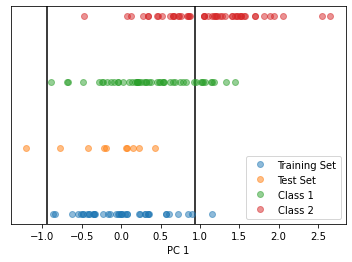

In [6]:
model = sklearn.decomposition.KernelPCA
kwargs = {"n_components":1, "kernel":"linear"}

m = EllipticManifold(0.05, model, kwargs)
_ = m.fit(X_train)

_ = m.visualize_1d([X_train, X_test, X_1, X_2], ["Training Set", "Test Set", "Class 1", "Class 2"])

In [7]:
m.score(X_test, [1]*len(X_test))

0.9

In [8]:
m.score(X_1, [-1]*len(X_1)) # 1D is not enough to distinguish class 0 from 1

0.2

In [9]:
# Try a 2D model instead
kwargs = {"n_components":2, "kernel":"linear"}

m = EllipticManifold(0.05, model, kwargs)

In [10]:
_ = m.fit(X_train)

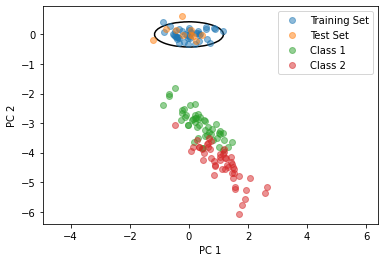

In [11]:
_ = m.visualize_2d([X_train, X_test, X_1, X_2], ["Training Set", "Test Set", "Class 1", "Class 2"])

In [12]:
m.predict(X_test, y_test)

array([ 1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1.,  1.])

In [13]:
m.score(X_test, [1]*len(X_test))

0.8

In [14]:
m.score(X_1, [-1]*len(X_1))

1.0

In [15]:
m.score(X_2, [-1]*len(X_2))

1.0

# Isomap Example

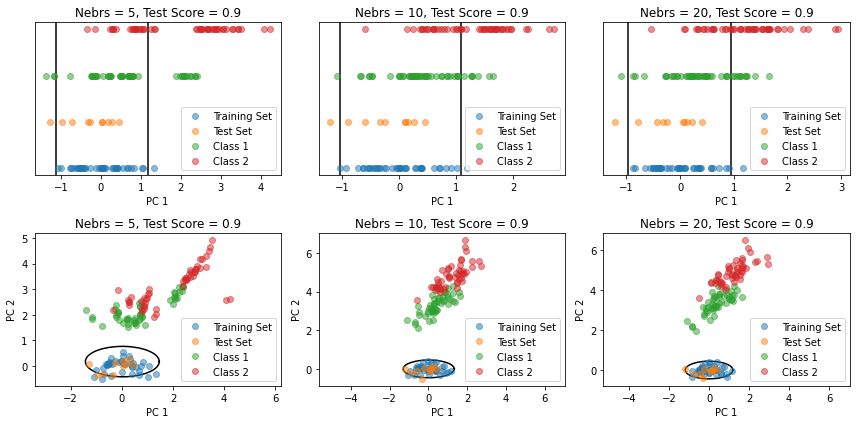

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,6))
ax = axes.flatten()

idx = 0
for dims in [1, 2]:
    for nebrs in [5, 10, 20]:
        model = sklearn.manifold.Isomap
        kwargs = {"n_neighbors":nebrs, 
                  "n_components":dims, 
                  "metric":'minkowski', 
                  "p":2, 
                 }
        m = EllipticManifold(0.05, model, kwargs)
        _ = m.fit(X_train)
        test_score = m.score(X_test, [1]*len(X_test))
        
        ax_ = m.visualize([X_train, X_test, X_1, X_2], ["Training Set", "Test Set", "Class 1", "Class 2"], ax[idx])
        ax_.set_title('Nebrs = {}, Test Score = {}'.format(nebrs, test_score))
        idx += 1

plt.tight_layout()

# LLE Example

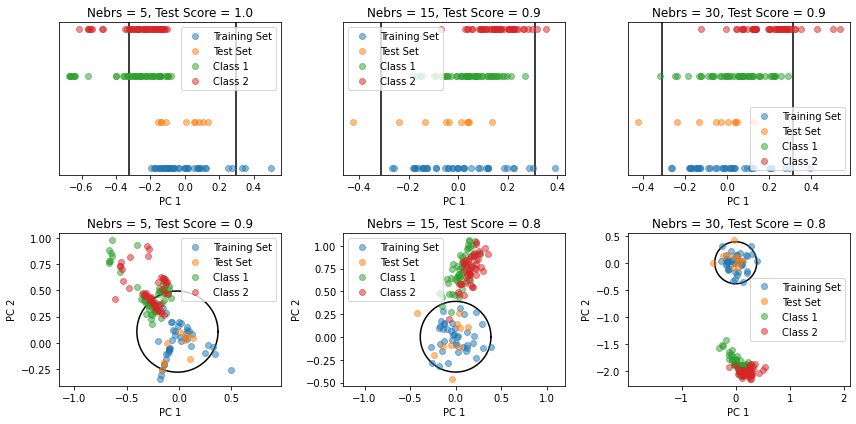

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,6))
ax = axes.flatten()

idx = 0
for dims in [1, 2]:
    for nebrs in [5, 15, 30]:
        model = sklearn.manifold.LocallyLinearEmbedding
        kwargs = {"n_neighbors":nebrs, 
                  "n_components":dims,
                 }
        m = EllipticManifold(0.05, model, kwargs)
        _ = m.fit(X_train)
        test_score = m.score(X_test, [1]*len(X_test))
        
        ax_ = m.visualize([X_train, X_test, X_1, X_2], ["Training Set", "Test Set", "Class 1", "Class 2"], ax[idx])
        ax_.set_title('Nebrs = {}, Test Score = {}'.format(nebrs, test_score))
        idx += 1

plt.tight_layout()

# UMAP Example

In [20]:
import umap
reducer = umap.UMAP()

AttributeError: module 'umap' has no attribute 'UMAP'

In [19]:
# un, semi, -supervised examples

In [26]:
??umap